In [67]:
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.io import write, read
from ase.lattice.surface import add_adsorbate
from ase.lattice.surface import fcc111
from gpaw import GPAW
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

In [38]:
#MOLECULE VIEWER CODE
from IPython.display import HTML
def atoms_to_html(atoms):
    'Return the html representation the atoms object as string'

    from tempfile import NamedTemporaryFile

    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html = ntf.read()
    return html

# 4,4'-bipyridine adsorption at Au(111) surface

In this tutorial we shall play with molecules at surfaces by adjusting their orientation and position. The aim of the actions is to design a system for a specific study, for example, specific adsorption, junction, partial charge transfer, which strongly depend on the adsorbate orientation and position.

## Literature overview

Vitali Grozovski, Vladislav Ivaništšev, Heili Kasuk, Tavo Romann, Enn Lust* **Balance of the interfacial interactions of 4,4 -bipyridine at Bi(111) surface**, *Electrochimica Acta 120 (2014) 86–95.

    "The 4,4-BP–Bi(111) interaction is the strongest for the orientation of the aromatic rings parallel to the surface plane. For the 4,4-BP orientation pointing N-atom towards the surface, there is a pronounced difference (>10 kJ/mol) in energy at the most and the least preferable positions for 4,4-BP molecules at the Bi(111)surface." (Grozovski et al 2014)
    
Parallel orientation is better, than perpendicular and N-orientations because of lower energy. 
    
    "The distance between the bismuth surface atoms is much larger than that for common d-metals–0.45 nm at Bi(111) vs. 0.29 nm at Au(111). Luckily, the distance between the centres of two aromatic rings of 4,4-BP (0.44 nm) fits the distance between the bismuth atoms at (111) surface (0.45 nm)" (Grozovski et al 2014)
    
It explains, why BP preffers adsorbate at Bi(111) with the orientation of the aromatic rings parallel to the surface plane.  
    
    "DFT calculation data demonstrated that a single 4,4-BP molecule prefers adsorption with the aromatic rings parallel to the Bi(111) surface. However, due to van der Waals attraction between the multiple molecules in the stripes, the 4,4-BP molecules (protonated) are oriented with their aromatic rings perpendicular to the surface plane. A good agreement between the theoretically modelled and the measured STM data, as well as between calculated and measured SEIRAS spectra, and electrochemical measurements supports the hypothesis of perpendicular alignment of the 4,4-BP molecules (ionic complexes) at Bi(111) surface, forming a monolayer of (4,4 - BPH 2 + )n, packed in ordered rows. We stress that the key factor leading to the formation of the nanoscale well-ordered structures on the single-crystal surfaces is the close matching of the optimum distance for intermolecular interactions with the distance between adsorption positions of molecules." (Grozovski et al 2014)
    
Due to the van der Waals attraction between the molecules, the 4,4-BP molecules are oriented perpendicular to the surface plane. This is due to the fact that the well-ordered structures on the single-crystal surfaces is the close matching of the optimum distance for intermolecular interactions with the distance between adsorption positions of molecules.


Yu-Xia Diao, Mei-Juan Han, Li-Jun Wan, Kingo Itaya, Taro Uchida, Hiroto Miyake, Akira Yamakata, Masatoshi Osawa* **Adsorbed Structures of 4,4′-Bipyridine on Cu(111) in Acid Studied by STM and IR**, *Langmuir 2006, 22, 3640-3646

    "At the positive potential region, BiPyH22+ is adsorbed on the surface with a flat-lying orientation and forms an ordered monolayer with (3 × 4) symmetry. Two pyridine rings in a molecule appears in a “8” shape. In the negative-potential region, BiPyH2•+ adopts a π-π stacking arrangement with a tilted orientation." (Diao et al 2006)

It is possible to change BP molecule orientation on surface by potential changing.


## Step by step example

Read 4,4'-bipyridine molecule coordinates

In [39]:
BP=read('44BP.xyz')
HTML(atoms_to_html(BP))

Create Au(111) surface

In [40]:
slab = fcc111('Au', size=(6,6,3), vacuum=8.0)
HTML(atoms_to_html(slab))

Fix all gold atom positions

In [41]:
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)

Add the 4,4'-bipyridine molecule to the slab at hight *h* and at a "bridge" position

In [42]:
h=10.
BP.rotate('y', pi/2)
BP.rotate('z', -pi/6)
add_adsorbate(slab, BP, h, 'bridge')

View the new slab–adsorbate system

In [43]:
HTML(atoms_to_html(slab))

Create a set of systems with variable distance between the 4,4'-bipyridine molecule and the surface. Use the simplest EMT calculator to get potential energy (which is meaningless due to the simplicity of the method, but the calculations are very fast).

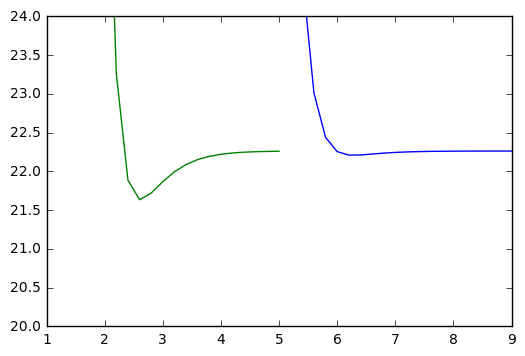

In [106]:
###            label  rotx  roty  rotz   shiftx   shifty   shiftz
sys = [[   'N_hlw_0',    0, pi/2,    0, 1.27650,-0.73700, 7.00000],
       ['par_top_60',    0,    0, pi/3, 0.00000, 0.00000, 3.00000],
       ['per_top_60', pi/2,    0, pi/3, 0.00000, 0.00000, 4.00000]]
step = [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

for i in range(len(sys)):
    f = open(str(sys[i][0])+'.dat','w')
    for j in range(len(step)):
        slab = fcc111('Au', size=(5,5,1), vacuum=8.0)
        BP=read('44BP.xyz')
        BP.rotate('x', sys[i][1])
        BP.rotate('y', sys[i][2])
        BP.rotate('z', sys[i][3])
        BP.translate(slab.positions[12]+(sys[i][4],sys[i][5],sys[i][6]+step[j]))
        slab+=BP
        calc  = EMT()
        slab.set_calculator(calc)
        e = slab.get_potential_energy()
        f.write(str(sys[i][6]+step[j])+' '+str(e)+'\n')
    
data = np.loadtxt(str(sys[0][0])+'.dat',unpack=True)
plt.plot(data[0], data[1])
data = np.loadtxt(str(sys[1][0])+'.dat',unpack=True)
plt.plot(data[0], data[1])
plt.ylim(20,24)
plt.show()

## More examples of 4,4'-bipyridine orientation and position at Au(111) surface
The orientation is defined relative to the surface normal and the *x*, *y*, *z* axes of the molecule as: (1) **N** – pointing one of the N atoms towards the surface; (2) **per** – the aromatic rings lying perpendicular to the surface; (3) **par** -- the aromatic rings lying parallel to the surface.
The position at the Au(111) surface is defined relative to one of the surface atoms and then shifted to "ontop", "bridge" or hollow positions.
The 4,4'-bipyridine molecule is also rotated along the *x*, *y*, *z* axes to suit the symmetry of the underlying surface.

### N orientation, rotate(90), hollow position

In [100]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=14.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=7.
BP.rotate('y', pi/2)
BP.rotate('z', pi/2)
BP.translate(slab.positions[62]+(1.44250,0.83283,h))
slab+=BP
HTML(atoms_to_html(slab))

### N orientation, rotate(0), ontop position

In [51]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=14.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=7.
BP.rotate('y', pi/2)
BP.translate(slab.positions[62]+(0,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### N orientation, rotate(90), bridge position

In [52]:
BP=read('44BP.xyz')
from ase.lattice.surface import fcc111
slab = fcc111('Au', size=(5,5,3), vacuum=14.0)
from ase.constraints import FixAtoms
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
from ase.lattice.surface import add_adsorbate
from math import pi
h=7.
BP.rotate('y', pi/2)
BP.translate(slab.positions[62]+(1.4425,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Par orientation, rotate(60), ontop position



In [53]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=4.
BP.rotate('z', pi/3)
BP.translate(slab.positions[62]+(0,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Par orientation, rotate(90), bridge position

In [54]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=4.
BP.rotate('z', pi/2)
BP.translate(slab.positions[62]+(1.4425,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Par orientation, rotate(90), hollow position

In [51]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=4.
BP.rotate('z', pi/2)
BP.translate(slab.positions[62]+(1.44250,0.83283,h))
slab+=BP
HTML(atoms_to_html(slab))

### Per orientation, rotate(60), bridge position

In [57]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=5.
BP.rotate('x', pi/2)
BP.rotate('z', pi/3)
BP.translate(slab.positions[62]+(1.4425,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Per orientation, rotate(45), ontop position

In [56]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=5.
BP.rotate('x', pi/2)
BP.rotate('z', pi/4)
BP.translate(slab.positions[62]+(0,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Per orientation, rotate(30), ontop position

In [55]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=5.
BP.rotate('x', pi/2)
BP.rotate('z', pi/6)
BP.translate(slab.positions[62]+(0,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Per orientation, rotate(22.5), bridge position

In [58]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=5.
BP.rotate('x', pi/2)
BP.rotate('z', pi/8)
BP.translate(slab.positions[62]+(1.4425,0,h))
slab+=BP
HTML(atoms_to_html(slab))

### Per orientation, rotate(45), hollow position


In [55]:
BP=read('44BP.xyz')
slab = fcc111('Au', size=(5,5,3), vacuum=8.0)
constraint = FixAtoms(mask=[a.symbol == 'Au' for a in slab])
slab.set_constraint(constraint)
h=5.
BP.rotate('x', pi/2)
BP.rotate('z', pi/4)
BP.translate(slab.positions[62]+(1.44250,0.83283,h))
slab+=BP
HTML(atoms_to_html(slab))